In [1]:
import datetime
import exifread
import matplotlib.pyplot as plt
import napari
import numpy as np
import numpy.ma as ma
import os
import tifffile

import pandas as pd
import seaborn as sns;


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib_scalebar import scalebar as sb
from pyneurotrace import analysis as pna
from pyneurotrace import filters as pnf
from pyneurotrace import notebook as pnb
from tqdm.notebook import trange, tqdm
from ScanImageTiffReader import ScanImageTiffReader
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from skimage import data, draw
from skimage.restoration import denoise_tv_chambolle
from skimage.registration import phase_cross_correlation
import skimage.measure as measure
from scipy import ndimage as ndi



In [2]:
%gui qt5
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [16, 10]

In [4]:
def returnChannels(image):
    ch1= np.zeros((int(image.shape[0]/2),image.shape[1],image.shape[2]))
    ch1_count=0
    ch2= np.zeros((int(image.shape[0]/2),image.shape[1],image.shape[2]))
    ch2_count=0

    for i in range(image.shape[0]):
        if i%2 == 0:
            ch1[ch1_count, :, :] = image[i, :, :]
            ch1_count+=1
        else:
            ch2[ch2_count, :, :] = image[i, :, :]
            ch2_count+=1
    
    return ch1, ch2

def returnStimList(file):
    stim_csv = np.loadtxt(open(file), delimiter=',')
    print(stim_csv[0,:])
    stim_list = []
    seconds = np.array([3600, 60, 1])
    for i in range(1, stim_csv.shape[0], 1):
        temp= (stim_csv[i,3:] - stim_csv[0,3:])
        stim_list.append(np.sum(temp*seconds))
    return stim_list

# Returns change in fluorescence over average fluorescence of ROI

def returnROITrace(video, mask):
    video_mask = video * mask
    video_mask[video_mask==0] = np.nan
    trace = np.zeros(video.shape[0])
    for i in range(video_mask.shape[0]):
        roi_avg = np.nanmean(video_mask[i, :, :])
        if np.isnan(roi_avg)==False:
            trace[i]= roi_avg
            lastNonNan = roi_avg
        else:
            trace[i]=lastNonNan
    return trace

# Offset correction
def returnOffsetCorr(movie):
    if np.min(movie)<0:
        movie = movie - np.min(movie)
    return movie




In [135]:
# CONSTANTS AND FILES
# PATH TO MOIVE FILE
FILE = '../GluSnfr3_210225/pcagStargazin+mscar/neuron-2/scan-4/file_00003.tif'

# CSV FOR STIM TIME
STIM_FILE ='../GluSnfr3_210225/pcagStargazin+mscar/neuron-2/scan-4/StimOutput02-25-2021 14-45.csv'


# Load the file
MOVIE = tifffile.imread(FILE)
print(MOVIE.shape)
if STIM_FILE is not None:
    STIM_LIST = returnStimList(STIM_FILE)
    
# Pull meta-data from the file    
metadata=ScanImageTiffReader(FILE).metadata()
metadata_dict = {}
metadata = metadata.split("\n")
for data in metadata:
    temp = data.split(" = ")
    if len(temp) > 1:
        metadata_dict[temp[0]] = temp[1]
        
        
# Saving the zoom of the factor      
ZOOM = metadata_dict['SI.hRoiManager.scanZoomFactor']
print('Image Zoom Facter: ', ZOOM)

# FRAME RATE
HZ = float(metadata_dict['SI.hRoiManager.scanFrameRate'])
print('Framerate: ', HZ)

# PIXEL VALUE IN REAL WORLD MEASUREMENTS (um)
PX = (162/MOVIE.shape[2])/int(ZOOM) 

# DFF FOR HOTSPOT DETECTION
THRESHOLD = .1

print('Channels Saved:', metadata_dict['SI.hChannels.channelSave'] )

(31174, 30, 128)
[2.0210e+03 2.0000e+00 2.5000e+01 1.4000e+01 4.2000e+01 5.5803e+01]
Image Zoom Facter:  5
Framerate:  67.4509
Channels Saved: [1;2]


In [136]:
# If more than one channel was recorded split the channels

if metadata_dict['SI.hChannels.channelSave'] is not '2':
    SPACEFILLER, MOVIE = returnChannels(MOVIE)


In [137]:
# View the Space Filler Channel
ViewSF = False

if ViewSF == True:
    viewer = napari.Viewer()
    viewer.add_image(SPACEFILLER)

In [138]:
print(np.min(MOVIE), np.max(MOVIE))
MOVIE = returnOffsetCorr(MOVIE)
print(np.min(MOVIE), np.max(MOVIE))
# VIEW THE MOVIE
viewer = napari.Viewer()
viewer.add_image(MOVIE)

-75.0 2046.0
0.0 2121.0


<Image layer 'MOVIE' at 0x7f98443a4da0>

In [139]:
# SMOOTH TO HELP STABILIZE IT
smooth_movie = np.zeros(MOVIE.shape)
for i in trange(MOVIE.shape[0]):
    smooth_movie[i,:,:] = denoise_tv_chambolle(MOVIE[i,:,:], weight=.0005)

viewer = napari.Viewer()
viewer.add_image(smooth_movie)

<Image layer 'smooth_movie' at 0x7f986d65ad30>

In [140]:
# CODE TO STABALIZE THE IMAGE USING PHASE CORRELATION

Stable_Image = np.zeros(MOVIE.shape)
Stable_Image[0, : : ] = MOVIE[0, :, :]

# COMPARES FRAMES AND CALCULATES THE DRIFT
for i in trange(MOVIE.shape[0]-1):
    shift, error, diffphase = phase_cross_correlation(smooth_movie[i, :,:], smooth_movie[(i+1),:,:], upsample_factor=100)
    # IF THE SHIFT IS GREATE THAN ZERO PIXELS APPLY A SHIFT TO THE ARRAY
    if (shift[0]> 0) or (shift[1] > 0):
        shifted_frame = ndi.interpolation.shift(MOVIE[(i+1),:,:], shift)
        Stable_Image[i+1, :,:] = shifted_frame
    else:
        Stable_Image[i+1, :,:] = MOVIE[(i+1),:,:]

In [141]:
# VIEW THE MOVIE, DETERMINE THE LAST FRAME BEFORE DRIFT IS TOO CRAZY
viewer = napari.Viewer()
viewer.add_image(Stable_Image)
print(Stable_Image.shape)

(15587, 30, 128)


In [143]:
# MANUALLY SET THE FRAMES TO PROCESS 
# SET AN INT FOR THE FIRST FRAME
FIRST_FRAME =0

# SET AN INT FOR THE LAST FRAME
LAST_FRAME = 15587

stable = Stable_Image[FIRST_FRAME:LAST_FRAME,:,:]

# Remove Border 
stable = stable[:, 1:-1, 1:-1]
viewer = napari.Viewer()
viewer.add_image(stable)

if STIM_FILE is not None:
    stim2plot = []
    for stim in STIM_LIST:
        if (FIRST_FRAME/HZ) <= stim <= (LAST_FRAME/HZ):
            stim2plot.append(stim - (FIRST_FRAME/HZ))

[9.005000000000003, 20.082, 29.161, 39.24, 49.331, 61.410000000000004, 72.485, 81.562, 92.636, 101.726, 109.805, 117.884, 127.96700000000001, 138.048, 146.132, 158.209]


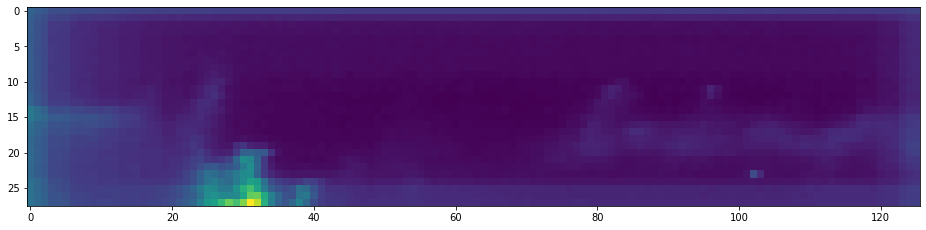

In [144]:
DENDRITE = np.std(stable, axis=0)
plt.imshow(DENDRITE)
print(stim2plot)
plt.show()


In [145]:
# Dictionary for Traces
trace_dict = {}


In [146]:
# Scan Images to see what regions have high correlation with neighbors

# Image Shape
x, y =DENDRITE.shape


# Dictionary to store hotspots
hotspot_coord = {}
pearson_dict = {}

counter = 1

# Tuples for neighboring boxes
tfn = [(-2,-2),(0,-2),(2,-2),(-2,0),(2,0),(-2,2),(0,2),(2,2),]

# Scan small areas across the images, ignoring the border
for i in trange(2, x-2, 2):
    for j in range(2, y-2, 2):
        avg_Pearson = np.zeros(8)

        if (i, j) in trace_dict:
            tempDFF = trace_dict[(i,j)]

        else: 
            pixeltrace = stable[:, i:i+2, j:j+2]                
            trace = np.nanmean(pixeltrace, axis=(1,2))
            tempDFF = pnf.deltaFOverF0(trace, HZ)
            trace_dict[(i,j)] = tempDFF                 
        
        for coord in tfn:
            if ((i+coord[0]),(j+coord[1])) in trace_dict:

                tempDFFNeigh = trace_dict[(i+coord[0],j+coord[1])] 
            else:
                pixeltraceNeigh = stable[:, i+coord[0]:(i+2+coord[0]), j+coord[1]:(j+2+coord[1])] 
                traceNeigh = np.nanmean(pixeltraceNeigh, axis=(1,2))
                tempDFFNeigh = pnf.deltaFOverF0(traceNeigh, HZ)
                trace_dict[(i+coord[0],j+coord[1])] = tempDFFNeigh                     
            pearsonR, _ = pearsonr(tempDFF, tempDFFNeigh)
            avg_Pearson[tfn.index(coord)] = pearsonR            
            
        hotspot_coord['Hotspot_{}'.format(counter)] = (j, i)
        pearson_dict['Hotspot_{}'.format(counter)] = np.mean(avg_Pearson)
        counter += 1
        

Plot the Avg Pearson's Correlation of a Point with it's Neighbors Trace
Max Correlation:  0.9145743804153518
Min Correlation:  -0.04420987181490913


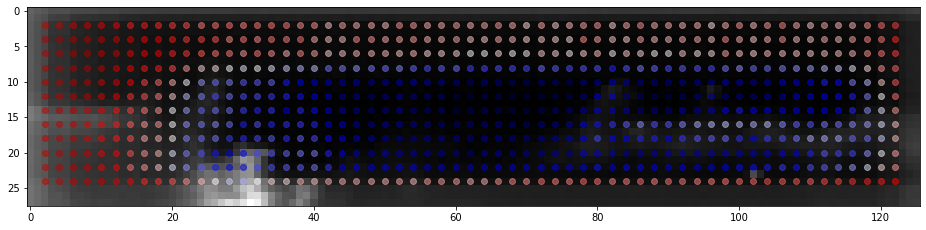

In [147]:
print("Plot the Avg Pearson's Correlation of a Point with it's Neighbors Trace")
print('Max Correlation: ',np.max(list(pearson_dict.values())))
print('Min Correlation: ',np.min(list(pearson_dict.values())))

# Plot the Pearson's Correlation of a Point with it's Neighbors Trace
seismic = cm.get_cmap('seismic', len(list(pearson_dict.values())))
plt.imshow(DENDRITE, cmap='Greys_r')
for key in hotspot_coord.keys():
    plt.plot(hotspot_coord[(key)][0], hotspot_coord[(key)][1], marker='o', color=seismic(pearson_dict[(key)]), alpha=.5)
plt.show()

In [148]:
# Scan Images to see what regions have high correlation after Stim
# Image Shape
x, y =DENDRITE.shape


# Dictionary to store hotspots
hotspot_coord = {}
pearsonVis_dict = {}

counter = 1

# Tuples for neighboring boxes
tfn = [(-2,-2),(0,-2),(2,-2),(-2,0),(2,0),(-2,2),(0,2),(2,2),]

# Scan small areas across the images, ignoring the border
for i in trange(2, x-2, 2):
    for j in range(2, y-2, 2):
        avg_Pearson = np.zeros(8)

        if (i, j) in trace_dict:
            tempDFF = trace_dict[(i,j)]

        else: 
            pixeltrace = stable[:, i:i+2, j:j+2]                
            trace = np.nanmean(pixeltrace, axis=(1,2))
            tempDFF = pnf.deltaFOverF0(trace, HZ)
            trace_dict[(i,j)] = tempDFF                 
        
        for coord in tfn:
            if ((i+coord[0]),(j+coord[1])) in trace_dict:

                tempDFFNeigh = trace_dict[(i+coord[0],j+coord[1])] 
            else:
                pixeltraceNeigh = stable[:, i+coord[0]:(i+2+coord[0]), j+coord[1]:(j+2+coord[1])] 
                traceNeigh = np.nanmean(pixeltraceNeigh, axis=(1,2))
                tempDFFNeigh = pnf.deltaFOverF0(traceNeigh, HZ)
                trace_dict[(i+coord[0],j+coord[1])] = tempDFFNeigh
            
            response = np.zeros((len(stim2plot), (int(2*HZ))))         
            responseNeigh = np.zeros((len(stim2plot), (int(2*HZ))))         

            for stim in stim2plot:
                if tempDFF[int(HZ*stim):].shape[0] > int(2*HZ):
                    response[stim2plot.index(stim), :] = tempDFF[int(HZ*stim):int(HZ*stim)+int(2*HZ)]    
                    responseNeigh[stim2plot.index(stim), :] = tempDFFNeigh[int(HZ*stim):int(HZ*stim)+int(2*HZ)]    
            response = np.ravel(response)
            responseNeigh = np.ravel(responseNeigh)
            pearsonR, _ = pearsonr(response, responseNeigh)
            avg_Pearson[tfn.index(coord)] = pearsonR            
            
        hotspot_coord['Hotspot_{}'.format(counter)] = (j, i)
        pearsonVis_dict['Hotspot_{}'.format(counter)] = np.mean(avg_Pearson)
        counter += 1
        

Plot the Avg Pearson's Correlation of a Point with it's Neighbors Trace After Stimulation
Max Correlation:  0.458872475758468
Min Correlation:  -0.11294005467694986


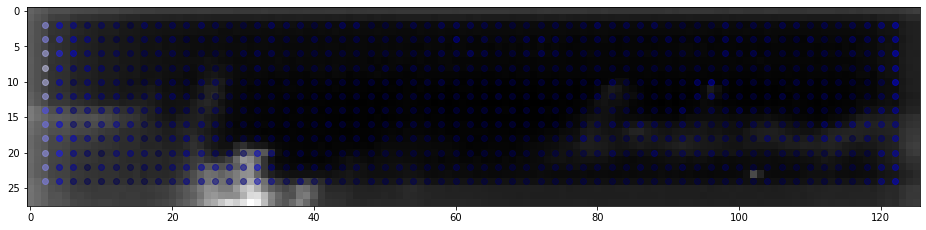

In [149]:
print("Plot the Avg Pearson's Correlation of a Point with it's Neighbors Trace After Stimulation")
print('Max Correlation: ',np.max(list(pearsonVis_dict.values())))
print('Min Correlation: ',np.min(list(pearsonVis_dict.values())))

# Plot the Pearson's Correlation of a Point with it's Neighbors Trace
seismic = cm.get_cmap('seismic', len(list(pearsonVis_dict.values())))
plt.imshow(DENDRITE, cmap='Greys_r')
for key in hotspot_coord.keys():
    plt.plot(hotspot_coord[(key)][0], hotspot_coord[(key)][1], marker='o', color=seismic(pearsonVis_dict[(key)]), alpha=.5)
plt.show()

In [150]:
# Scan Images to see what regions have high correlation with neighbors outside of stim
# Image Shape
x, y =DENDRITE.shape


# Dictionary to store hotspots
hotspot_coord = {}
pearsonStoc_dict = {}

counter = 1

# Tuples for neighboring boxes
tfn = [(-2,-2),(0,-2),(2,-2),(-2,0),(2,0),(-2,2),(0,2),(2,2),]

# Scan small areas across the images, ignoring the border
for i in trange(2, x-2, 2):
    for j in range(2, y-2, 2):
        avg_Pearson = np.zeros(8)

        if (i, j) in trace_dict:
            tempDFF = trace_dict[(i,j)]

        else: 
            pixeltrace = stable[:, i:i+2, j:j+2]                
            trace = np.nanmean(pixeltrace, axis=(1,2))
            tempDFF = pnf.deltaFOverF0(trace, HZ)
            trace_dict[(i,j)] = tempDFF                 
        
        for coord in tfn:
            if ((i+coord[0]),(j+coord[1])) in trace_dict:

                tempDFFNeigh = trace_dict[(i+coord[0],j+coord[1])] 
            else:
                pixeltraceNeigh = stable[:, i+coord[0]:(i+2+coord[0]), j+coord[1]:(j+2+coord[1])] 
                traceNeigh = np.nanmean(pixeltraceNeigh, axis=(1,2))
                tempDFFNeigh = pnf.deltaFOverF0(traceNeigh, HZ)
                trace_dict[(i+coord[0],j+coord[1])] = tempDFFNeigh
            
            response = np.array(0)   
            responseNeigh = np.array(0)            

            for stim in stim2plot:
                if tempDFF[int(HZ*stim):].shape[0] > int(2*HZ):
                    if stim2plot.index(stim) ==0 :
                        response = np.append(response, tempDFF[0:int(HZ*stim)+int(2*HZ)])    
                        responseNeigh = np.append(responseNeigh, tempDFFNeigh[0:int(HZ*stim)+int(2*HZ)])  
                        lastStim =int(HZ*stim)+int(2*HZ)
                   
                    if stim2plot.index(stim) == (len(stim2plot)-1):
                        response = np.append(response, tempDFF[int(HZ*stim)+int(2*HZ):])    
                        responseNeigh = np.append(responseNeigh, tempDFFNeigh[int(HZ*stim)+int(2*HZ):]) 
                    
                    else: 
                        response = np.append(response, tempDFF[lastStim:int(HZ*stim)+int(2*HZ)])    
                        responseNeigh = np.append(responseNeigh, tempDFFNeigh[lastStim:int(HZ*stim)+int(2*HZ)])  
                        lastStim =int(HZ*stim)+int(2*HZ)

            pearsonR, _ = pearsonr(response, responseNeigh)
            avg_Pearson[tfn.index(coord)] = pearsonR            
            
        hotspot_coord['Hotspot_{}'.format(counter)] = (j, i)
        pearsonStoc_dict['Hotspot_{}'.format(counter)] = np.mean(avg_Pearson)
        counter += 1
        

Plot the Avg Pearson's Correlation of a Point with it's Neighbors - Stochastic
Max Correlation:  0.9173621383990858
Min Correlation:  -0.04608313021630543


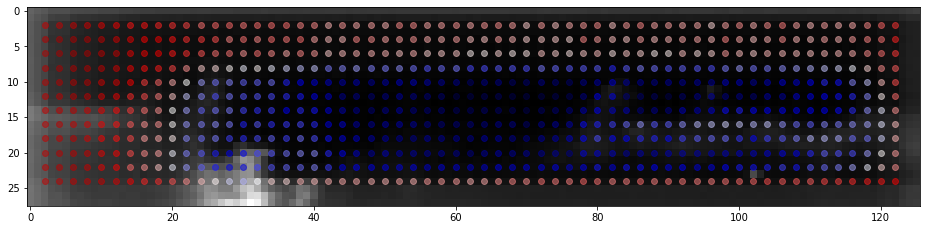

In [151]:
print("Plot the Avg Pearson's Correlation of a Point with it's Neighbors - Stochastic")
print('Max Correlation: ',np.max(list(pearsonStoc_dict.values())))
print('Min Correlation: ',np.min(list(pearsonStoc_dict.values())))

# Plot the Pearson's Correlation of a Point with it's Neighbors Trace
seismic = cm.get_cmap('seismic', len(list(pearsonStoc_dict.values())))
plt.imshow(DENDRITE, cmap='Greys_r')
for key in hotspot_coord.keys():
    plt.plot(hotspot_coord[(key)][0], hotspot_coord[(key)][1], marker='o', color=seismic(pearsonStoc_dict[(key)]), alpha=.5)
plt.show()

In [152]:
# Plot traces?
SHOW_TRACES = False

# Scan Images for Visually Invoked Responses
# Image Shape
x, y =DENDRITE.shape


# Dictionary to store hotspots
hotspot= {}
hotspot_max= {}
counter = 1

# Scan small areas across the images, ignoring the border
for i in trange(2, x-2, 2):
    for j in range(2, y-2, 2):
        plotBoolean = False
        if (i, j) in trace_dict:
            tempDFF = trace_dict[(i,j)]

        else: 
            pixeltrace = stable[:, i:i+2, j:j+2]                
            trace = np.nanmean(pixeltrace, axis=(1,2))
            tempDFF = pnf.deltaFOverF0(trace, HZ)
            trace_dict[(i,j)] = tempDFF  
        if STIM_FILE is not None:
            response = np.zeros((len(stim2plot), (int(3*HZ))-1))         
            for stim in stim2plot:
                if tempDFF[int(HZ*stim):].shape[0] > int(3*HZ):
                    response[stim2plot.index(stim), :] = tempDFF[int(HZ*stim)-int(HZ*1):int(HZ*stim)+int(2*HZ)]
            avg_trace = response.copy() 
            avg_trace[avg_trace==0] ==np.nan  
            avg_trace = np.nanmean(response, axis=0)
            if np.max(avg_trace) > THRESHOLD:
                if int(np.mean(np.where(avg_trace == np.max(avg_trace))))< int(1.5*HZ):
                    prepeaks, _ = find_peaks(avg_trace[:int(1*HZ)], prominence=(2*np.std(avg_trace[:int(1*HZ)])+np.mean(avg_trace[:int(1*HZ)])))
                    postpeaks, _ = find_peaks(avg_trace[int(1*HZ):], prominence=(2*np.std(avg_trace[:int(1*HZ)])+np.mean(avg_trace[:int(1*HZ)])))

                    if (postpeaks.shape[0]>prepeaks.shape[0]) and (postpeaks.shape[0] is not 0):

                            plotBoolean = True
                            hotspot['Hotspot_{}'.format(counter)] = (j, i)
                            hotspot_max['Hotspot_{}'.format(counter)] = np.max(avg_trace)
                            counter += 1
                    if SHOW_TRACES == True:
                        if plotBoolean == True:
                            avg_time = np.arange(avg_trace.shape[0])/HZ

                            for k in range(response.shape[0]):
                                plt.plot(avg_time, response[k, :], linewidth=1, color='grey')

                            plt.plot(avg_time, avg_trace, linewidth=3)
                            plt.axvline(x=int(1))
                            plt.ylim([-0.2,1])

                            print('Hotspot_{}'.format(counter-1))
                            plt.show()


In [153]:

if (len(hotspot_max.values())==0):
    display("No Visually Evoked Hotspots Detected")

else: 
    # Plot Potential Locations of Visually Invoked Responses
    max_peak = (np.max(list(hotspot_max.values())))
    print(max_peak)
    inferno = cm.get_cmap('inferno', len(list(hotspot_max.values())))
    plt.imshow(DENDRITE, cmap='Greys_r')
    for key in hotspot.keys():
        plt.plot(hotspot[(key)][0], hotspot[(key)][1], marker='o', color=inferno(hotspot_max[(key)]/max_peak))
    plt.show()

'No Visually Evoked Hotspots Detected'

In [154]:
# Create a Correlation Plot for Traces of Hot Spots
if (len(hotspot_max.values())==0):
    display("No Visually Evoked Hotspots Detected")

else:
    heatmap = pd.DataFrame(index=hotspot.keys(), columns=hotspot.keys())
    for keyi in hotspot.keys():
        for keyj in hotspot.keys():

            heatmap[keyi][keyj], _ = pearsonr(trace_dict[(hotspot[(keyi)][1], hotspot[(keyi)][0])], trace_dict[(hotspot[(keyj)][1], hotspot[(keyj)][0])])
    heatmap = heatmap.astype('float')
    ax = sns.heatmap(heatmap, cmap='seismic')

'No Visually Evoked Hotspots Detected'

In [155]:
# PAINT THE ROI IN THE NAPARI WINDOW
ROI = np.zeros(DENDRITE.shape)
roi_painter = napari.Viewer()
roi_painter.add_image(DENDRITE)
roi_painter.add_labels(ROI)


<Labels layer 'ROI' at 0x7f9844316ef0>

[0.]


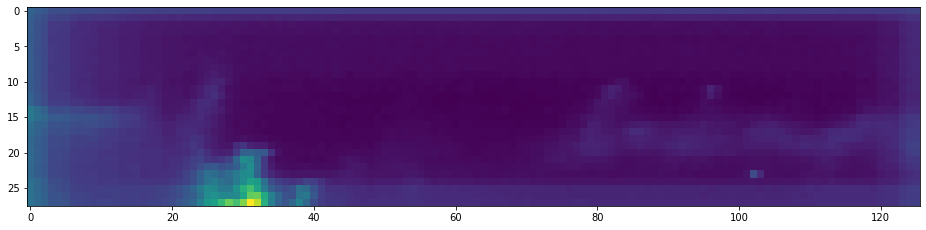

In [156]:
# DISPLAY THE IMAGING AREA AND ROIs
plt.imshow(DENDRITE)
ROI_LABLES = np.unique(ROI)
print(ROI_LABLES)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = np.nan      
        plt.imshow(mask, cmap='rainbow')

In [159]:
# Calculte the DFF for each ROI and save it to a dict

ROI_LABLES = np.unique(ROI)
raw_dict = {}
dff_dict = {}
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        
        # Return the average intensity value for the roi
        roi_trace = returnROITrace(stable, mask)
        
        # Added the trace a to dictionary
        raw_dict[roi] = roi_trace
        
        # Remove shot noise
        roi_trace = pnf.okada(roi_trace)
        
        # Calculate Df/F
        roi_trace = pnf.deltaFOverF0(roi_trace, HZ, None)
        dff_dict[roi] = roi_trace

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


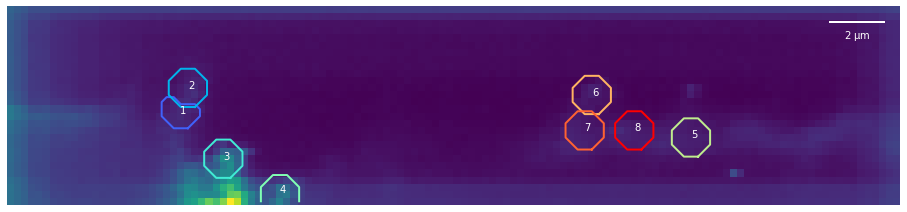

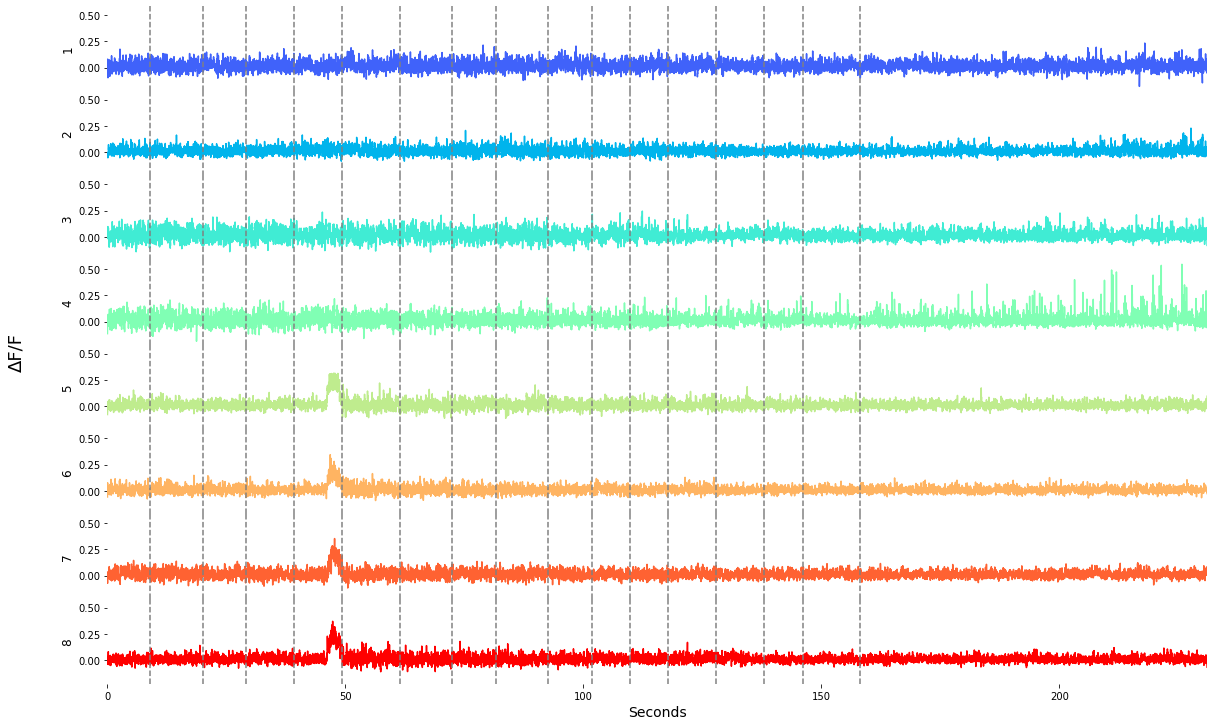

In [160]:
# Graph the ROI overs the STD projection and plot DF/F traces

rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(stable.shape[0])/HZ


fig2, ax1 = plt.subplots()
ax1.axis("off")
scalebar = sb.ScaleBar(
    PX,
    "um",
    box_color =None,
    box_alpha=0,
    length_fraction=0.1,
    scale_loc="bottom",
    border_pad=1,
    pad=.5,
    color ='white'
)
ax1.add_artist(scalebar)

fig, axs = plt.subplots((len(ROI_LABLES)-1), sharex=True,sharey=True, )
fig.tight_layout()
fig.text(-0.05,0.5, "ΔF/F", ha="center", va="center", rotation=90, fontsize=18)
ax1.imshow(DENDRITE)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        com = ndi.measurements.center_of_mass(mask)
        contour = measure.find_contours(mask, .3)
        ax1.plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        ax1.text(com[1],com[0], s=str(int(roi)), color='white')
        
        
        axs[int(roi)-1].plot(time, dff_dict[roi], linewidth=1.5, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)-1].set_xlim([0,np.max(time)])
        if STIM_FILE is not None:
            for stim in stim2plot:
                axs[int(roi)-1].axvline(x=(stim), ls='--', color='grey')
        axs[int(roi)-1].set_ylabel(str(int(roi)),  fontsize=12)        
        axs[int(roi)-1].spines['top'].set_visible(False)
        axs[int(roi)-1].spines['right'].set_visible(False)
        axs[int(roi)-1].spines['bottom'].set_visible(False)
        axs[int(roi)-1].spines['left'].set_visible(False)
        if int(roi) == (len(ROI_LABLES)-1):
            axs[int(roi)-1].set_xlabel('Seconds',  fontsize=14)
        else:
            axs[int(roi)-1].xaxis.set_ticks_position('none')

plt.subplots_adjust(wspace=0, hspace=0)

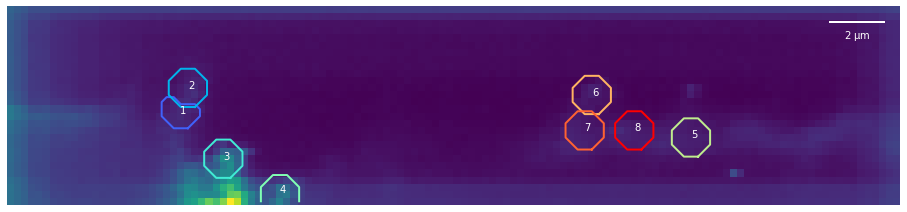

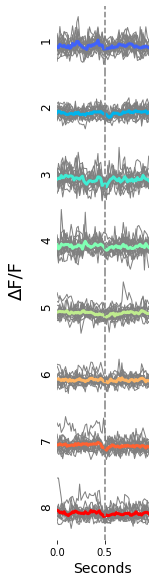

In [161]:
# Graph the ROI overs the STD projection and plot DF/F traces

rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(stable.shape[0])/HZ


fig2, ax1 = plt.subplots()
ax1.axis("off")
scalebar = sb.ScaleBar(
    PX,
    "um",
    box_color =None,
    box_alpha=0,
    length_fraction=0.1,
    scale_loc="bottom",
    border_pad=1,
    pad=.5,
    color='white'
)
ax1.add_artist(scalebar)

fig, axs = plt.subplots((len(ROI_LABLES)-1), sharex=True,sharey=True, figsize=(2, 8))
fig.tight_layout()
fig.text(-0.05,0.5, "ΔF/F", ha="center", va="center", rotation=90, fontsize=18)
ax1.imshow(DENDRITE)
for roi in ROI_LABLES:
    if roi > 0:
        # Plot Contours of ROI on the STD Image
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        # Center of Mass for the ROI label 
        com = ndi.measurements.center_of_mass(mask)
        contour = measure.find_contours(mask, .3)     
        ax1.plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        ax1.text(com[1],com[0], s=str(int(roi)), color='white')
        
        # Get DFF Trace to Get Average Signal After Stim
        tempDFF = dff_dict[roi].copy()
        if STIM_FILE is not None:
            response = np.zeros((len(stim2plot), (int(1*HZ))-1))         
            for stim in stim2plot:
                response[stim2plot.index(stim), :] = tempDFF[int(HZ*stim)-int(HZ*.5):int(HZ*stim)+int(.5*HZ)]
            avg_trace = response.copy() 
            avg_trace[avg_trace==0] ==np.nan
            avg_trace = np.nanmean(response, axis=0)
            avg_time = np.arange(avg_trace.shape[0])/HZ

            for k in range(response.shape[0]):
                 axs[int(roi)-1].plot(avg_time, response[k, :], linewidth=1, color='grey')

            axs[int(roi)-1].plot(avg_time, avg_trace, linewidth=3, color=rainbow(roi/ROI_LABLES.max()))
            axs[int(roi)-1].axvline(x=0.5, color='grey', ls='--')      
            axs[int(roi)-1].set_xlim([0,np.max(avg_time)])
            axs[int(roi)-1].set_ylabel(str(int(roi)),  fontsize=12)        
            axs[int(roi)-1].spines['top'].set_visible(False)
            axs[int(roi)-1].spines['right'].set_visible(False)
            axs[int(roi)-1].spines['bottom'].set_visible(False)
            axs[int(roi)-1].spines['left'].set_visible(False)
            axs[int(roi)-1].set_yticks([])
            axs[int(roi)-1].yaxis.set_ticks_position('none')
            if int(roi) == (len(ROI_LABLES)-1):
                axs[int(roi)-1].set_xlabel('Seconds',  fontsize=14)
            else:
                axs[int(roi)-1].xaxis.set_ticks_position('none')

plt.subplots_adjust(wspace=0, hspace=0)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Amplitued:  0.049699752098304066 
 Onset Time:  -1.1055911619107948 
 Rise Time:  6.73028379156336 
 Decay Time:  33.35342451768365 



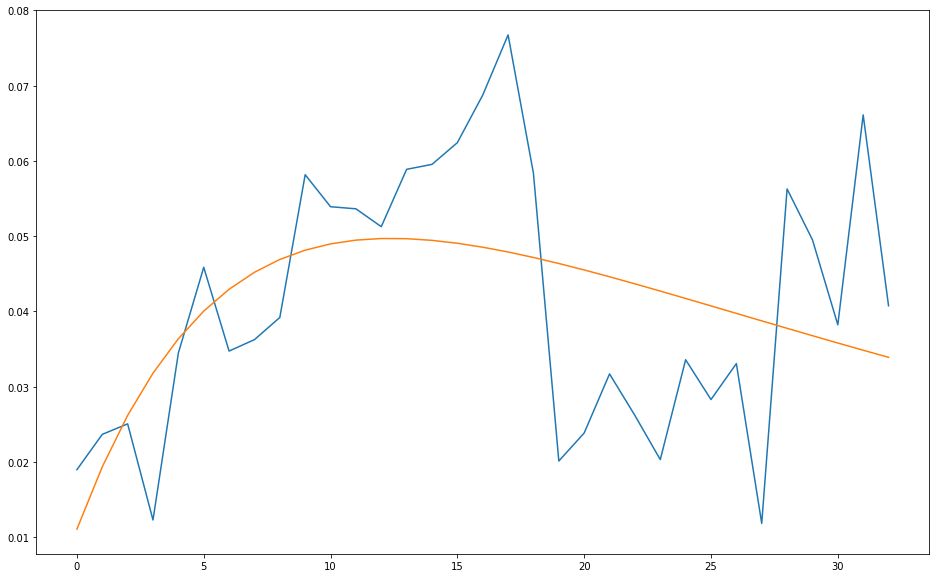

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Amplitued:  0.02655542228821456 
 Onset Time:  0.6753714157737647 
 Rise Time:  3.4368697717901875 
 Decay Time:  42.31250066631204 



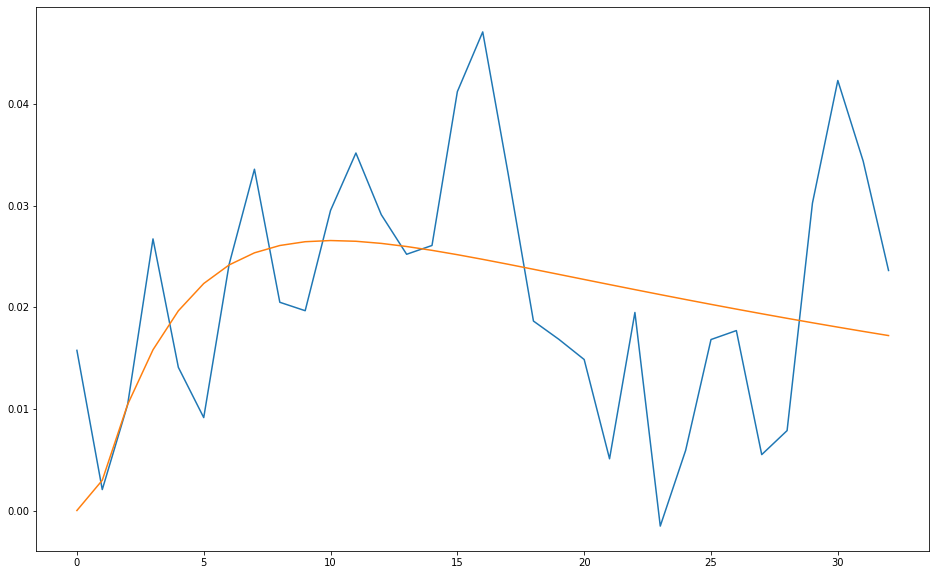

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Amplitued:  0.05724305988693994 
 Onset Time:  -104.90129187443839 
 Rise Time:  1019.1403482317045 
 Decay Time:  1029.2273833128777 



/home/peter/.local/lib/python3.6/site-packages/pyneurotrace/analysis.py:24: RuntimeWarning: overflow encountered in power
  scale = A * np.power(tA, tA / (tA - tB)) * np.power(tB, tB / (tB - tA)) / (tB - tA)


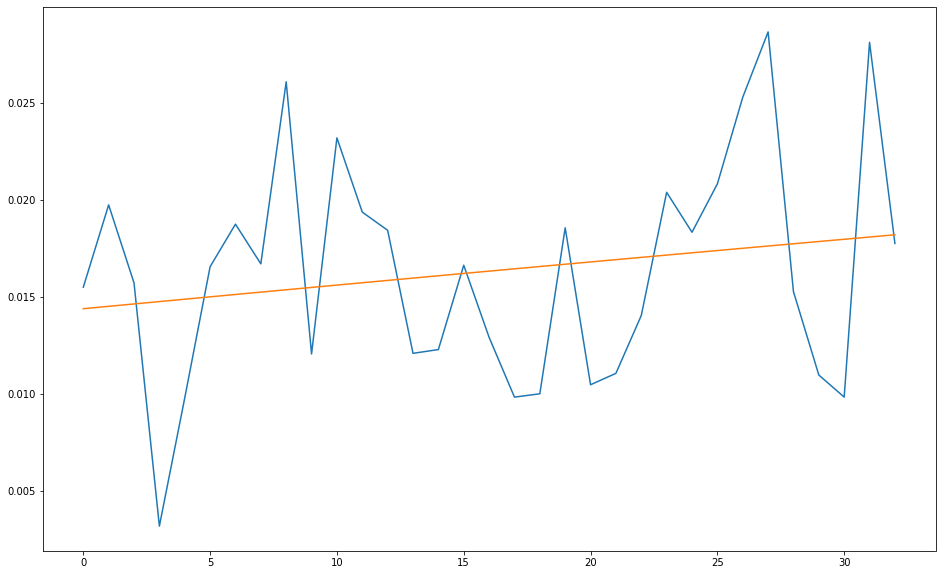

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Amplitued:  0.03641400050442562 
 Onset Time:  6.813880990601226 
 Rise Time:  1.843692732677291 
 Decay Time:  13.15668236431727 



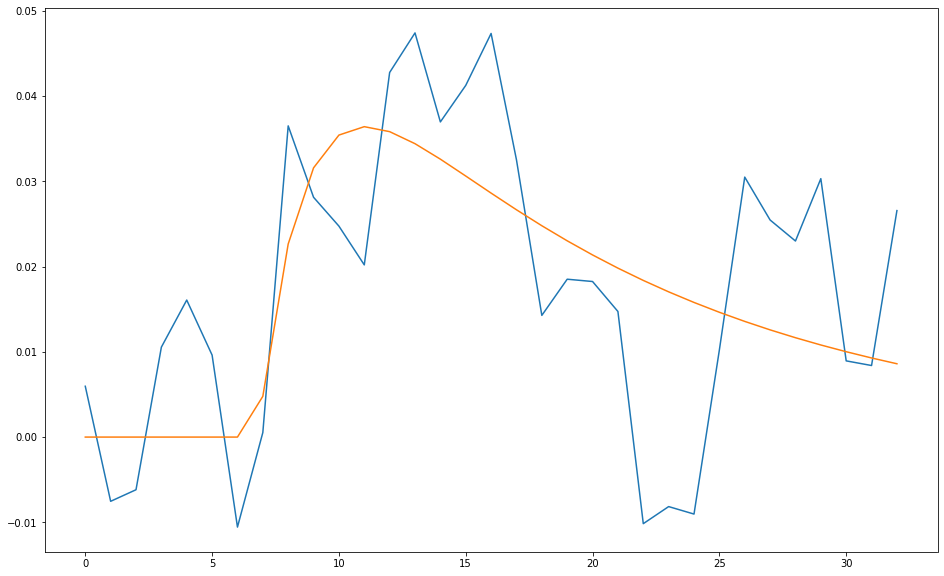

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Amplitued:  0.05471110223748397 
 Onset Time:  -1.2975683737566566 
 Rise Time:  1.823307819985527 
 Decay Time:  66.96043669951165 



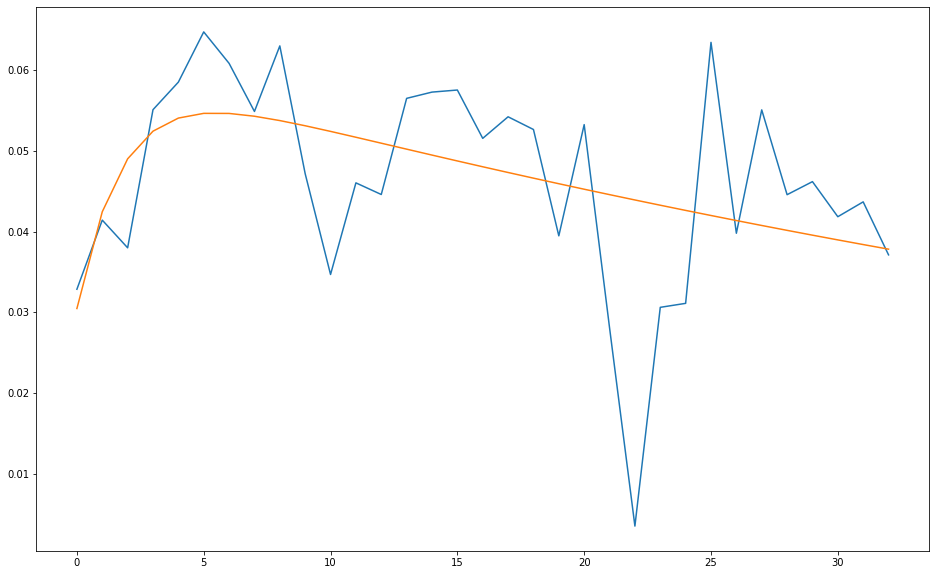

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Amplitued:  0.06419322164056644 
 Onset Time:  -12.909736610303796 
 Rise Time:  17.782248654564306 
 Decay Time:  9999.456715199382 



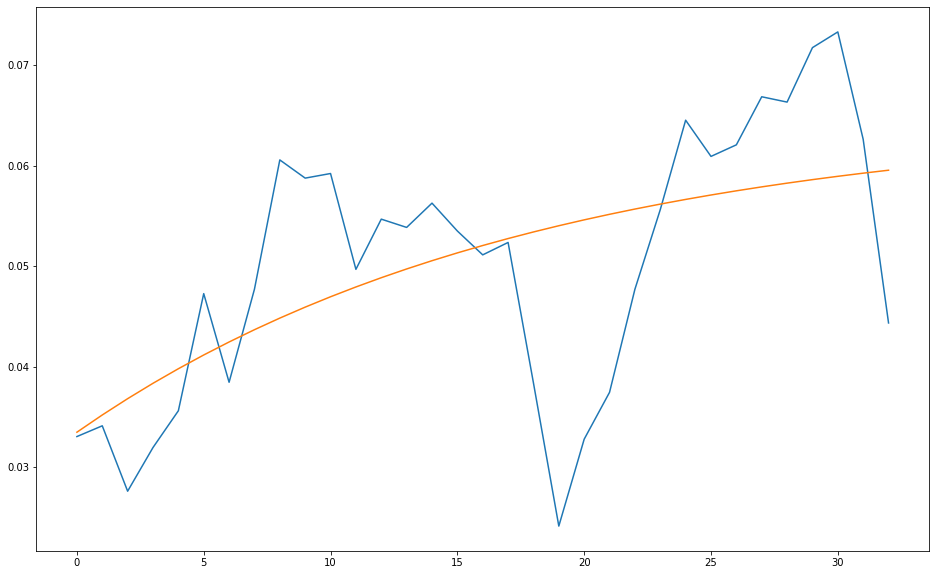

In [87]:
for roi in ROI_LABLES:
    if roi > 0:
        tempDFF = dff_dict[roi].copy()
        if STIM_FILE is not None:
            response = np.zeros((len(stim2plot), (int(.5*HZ))))         
            for stim in stim2plot:
                response[stim2plot.index(stim), :] = tempDFF[int(HZ*stim):int(HZ*stim)+int(.5*HZ)]
            avg_trace = response.copy() 
            avg_trace[avg_trace==0] ==np.nan
            avg_trace = np.nanmean(response, axis=0)
            avg_trace =np.nan_to_num(avg_trace)
            print(np.isfinite(avg_trace))
            results = pna.fitDoubleExp(avg_trace, HZ)
            print(
                "Amplitued: ", results[0][0], '\n',
                "Onset Time: ", results[0][1], '\n',
                "Rise Time: ", results[0][2], '\n',
                "Decay Time: ", results[0][3], '\n',
                 )
            plt.plot(avg_trace)
            plt.plot(results[1])
            plt.show()
            


(array([3.84806966e-02, 3.00978473e+00, 3.64971675e-03, 3.11724947e+02]),
 array([0.        , 0.        , 0.        , 0.        , 0.0383642 ,
        0.03824133, 0.03811885, 0.03799676, 0.03787507, 0.03775376,
        0.03763284, 0.03751231, 0.03739216, 0.0372724 , 0.03715303,
        0.03703403, 0.03691542, 0.03679719, 0.03667933, 0.03656185,
        0.03644475, 0.03632803, 0.03621168, 0.0360957 , 0.03598009,
        0.03586485, 0.03574998, 0.03563548, 0.03552135, 0.03540758,
        0.03529418, 0.03518113, 0.03506846, 0.03495614, 0.03484418,
        0.03473258, 0.03462134, 0.03451045, 0.03439992, 0.03428975,
        0.03417992, 0.03407045, 0.03396133, 0.03385256, 0.03374413,
        0.03363606, 0.03352833, 0.03342094, 0.0333139 , 0.0332072 ,
        0.03310085, 0.03299483, 0.03288915, 0.03278382, 0.03267881,
        0.03257415, 0.03246982, 0.03236583, 0.03226216, 0.03215884,
        0.03205584, 0.03195317, 0.03185083, 0.03174881, 0.03164713,
        0.03154577, 0.03144473, 0.03134402

In [39]:
# Save the drawn ROI for use later 
time_stamp = str(datetime.datetime.now())
time_stamp = time_stamp.replace(':', '')
filename = (os.path.splitext(os.path.basename(FILE))[0])

# Unique File Identifier with timestamp 
ufID = 'ROI_LABELS_%s_%s' %(filename, time_stamp)

# Create Directory to store ROI
if not os.path.exists('saved_rois'):
    os.mkdir('saved_rois')

# Save ROI 
np.save("saved_rois/%s"%(ufID), ROI)